<a href="https://colab.research.google.com/github/arahmanmdmajid/DS_AI_11/blob/main/CV_Mini_Project_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  Model Comparison Table

| Feature             | MobileNetV2 | ResNet50 |
|---------------------|-------------|----------|
| Input Image Size    | (224,224,3) | (224,224,3)|
| Parameters          | 3.5M        | 25.6M    |
| Layers / Depth      | 105          | 107      |
| ImageNet Accuracy   | 71.3%       | 74.9%    |
| Model Size (MB)     | ~14 MB      | ~98 MB   |
| Inference Speed     | 25.9 ms     | 58.2 ms  |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model, Model
from sklearn.model_selection import train_test_split

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [28]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=IMG_SHAPE)

In [4]:
# Model input shape for MobileNetV2
input_shape_mobilenet = model_mobilenet.input_shape
print(f"MobileNetV2 Input Image Size: {input_shape_mobilenet[1:]}")

MobileNetV2 Input Image Size: (224, 224, 3)


Rock-Paper-Scissors Dataset Selected


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanikamal/rock-paper-scissors-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'rock-paper-scissors-dataset' dataset.
Path to dataset files: /kaggle/input/rock-paper-scissors-dataset


In [8]:
import os
print(os.listdir('/kaggle/input/rock-paper-scissors-dataset'))

['Rock-Paper-Scissors', 'rock-paper-scissors']


In [9]:
train_dir = os.path.join(path, 'Rock-Paper-Scissors/train')
test_dir = os.path.join(path, 'Rock-Paper-Scissors/test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [10]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [1 1 1 2 1 0 0 1 0 2 1 1 2 1 1 2 1 1 2 0 2 0 0 0 0 1 2 0 1 0 2 0]


In [11]:
class_names = train_dataset.class_names
print(class_names)

['paper', 'rock', 'scissors']


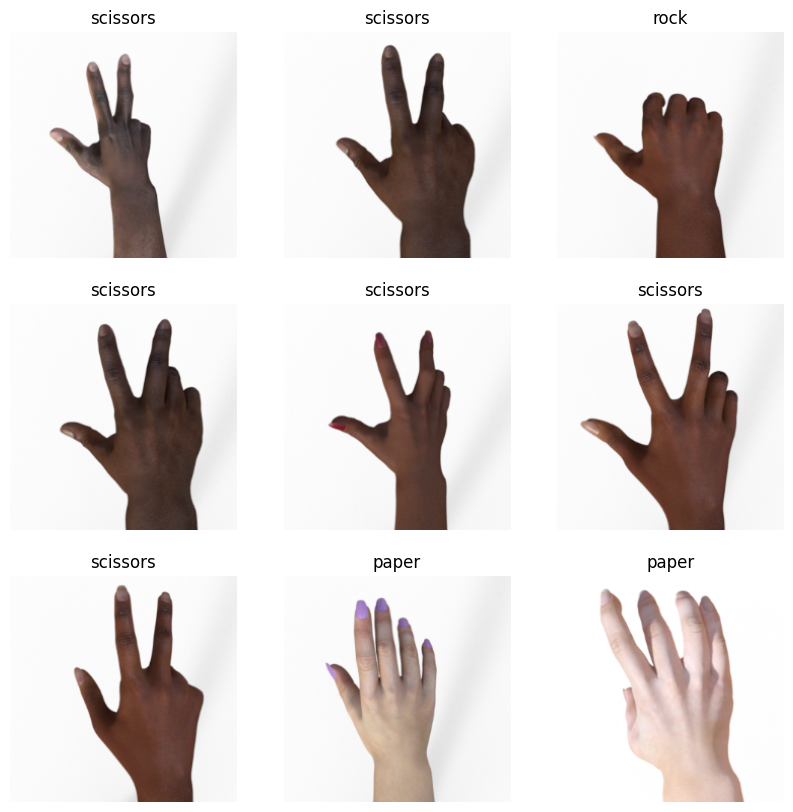

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(4* val_batches // 5)
validation_dataset = validation_dataset.skip(4* val_batches // 5)

In [14]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 79
Number of validation batches: 3
Number of test batches: 9


In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Apply preprocessing
def preprocess(image, label):
    image = preprocess_input(image)  # scale and normalize
    return image, label

In [16]:
train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)

# Prefetch for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
model_mobilenet.trainable = False

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = model_mobilenet(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.3802 - loss: 1.1473
initial loss: 1.14
initial accuracy: 0.42


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 264ms/step - accuracy: 0.4204 - loss: 1.1524 - val_accuracy: 0.6429 - val_loss: 0.7957
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7290 - loss: 0.7182 - val_accuracy: 0.7500 - val_loss: 0.6434
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.9055 - loss: 0.4657 - val_accuracy: 0.8810 - val_loss: 0.5176
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.9234 - loss: 0.3594 - val_accuracy: 0.8571 - val_loss: 0.4930
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9622 - loss: 0.2735 - val_accuracy: 0.7976 - val_loss: 0.5034
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9650 - loss: 0.2277 - val_accuracy: 0.8810 - val_loss: 0.4317
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9756 - loss: 0.1889 - val_accuracy: 0.8571 - val_loss: 0.3596
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.9802 - loss: 0.1579 - val_accuracy: 0.8810

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

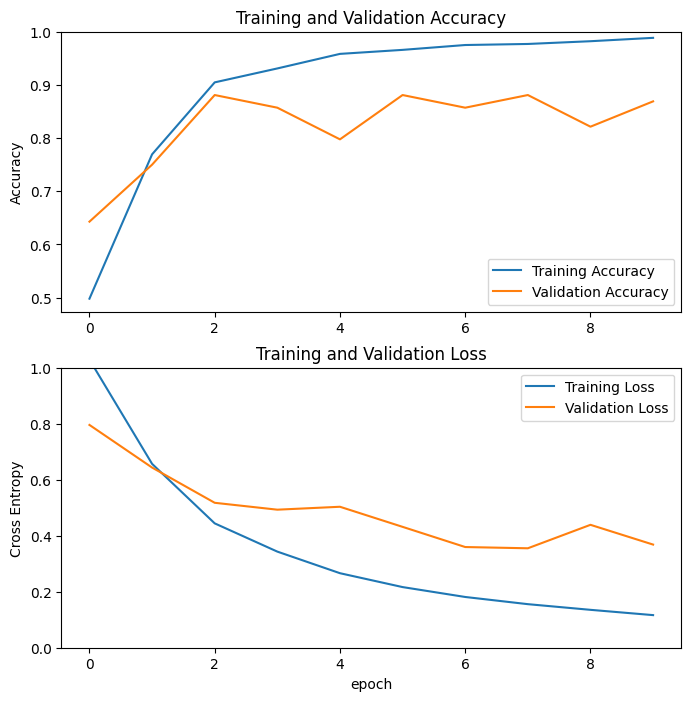

In [23]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
model_mobilenet.trainable = True

# Fine-tuning from this layer onwards
fine_tune_at = 100

# Freezing all the layers before the `fine_tune_at` layer
for layer in model_mobilenet.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [25]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 368ms/step - accuracy: 0.9097 - loss: 0.3122 - val_accuracy: 0.8214 - val_loss: 0.4199
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 1.0000 - loss: 0.0277 - val_accuracy: 0.7500 - val_loss: 0.5456
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.7381 - val_loss: 0.6786
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.8452 - val_loss: 0.3999
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8214 - val_loss: 0.4148
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.8929 - val_loss: 0.2591
Epoch 16/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 1.0000 - loss: 7.3281e-04 - val_accuracy: 0.7857 - val_loss: 0.5659
Epoch 17/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 1.0000 - loss: 3.7761e-04 - val_

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

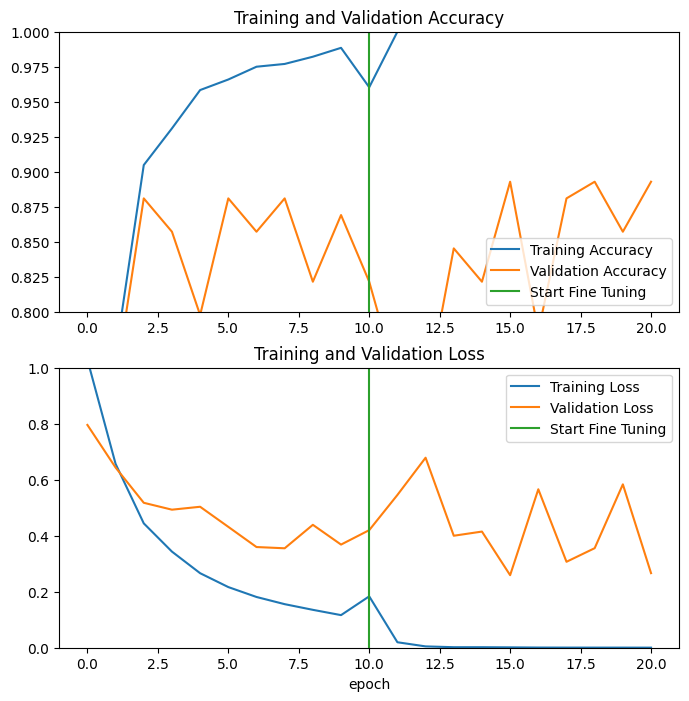

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
# Predictions on the test dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


In [32]:
predicted_labels[0]

np.int64(2)

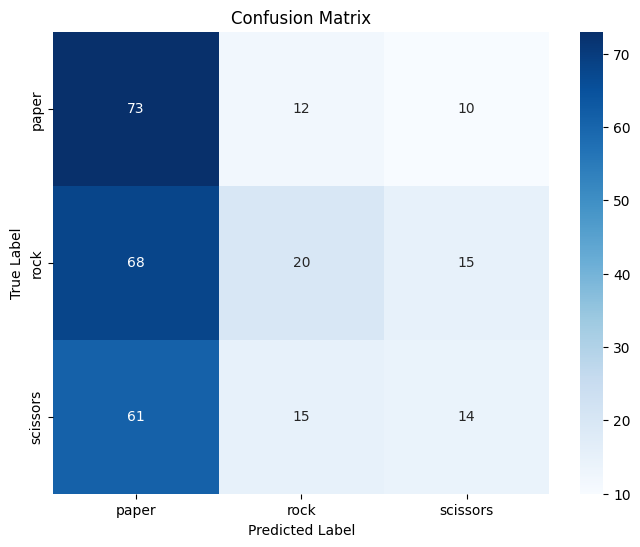

In [37]:
# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Justification for MobileNetV2 over ResNet50

Based on the provided comparison table provided earlier we selected MobileNetV2 for the following reasons

1.  **Fewer Parameters**: MobileNetV2 has substantially fewer parameters (3.5M vs 25.6M), leading to a much smaller model size (~14 MB vs ~98 MB). This is beneficial for deployment on devices with limited memory and computational resources.
2.  **Faster Inference Speed**: MobileNetV2 demonstrates a faster inference speed (25.9 ms vs 58.2 ms). This is important for applications requiring real-time or near real-time predictions.
3.  **Efficiency for Transfer Learning**: Given the relatively smaller size and complexity of the Rock-Paper-Scissors dataset compared to ImageNet, the efficiency of MobileNetV2 makes it a practical choice for transfer learning.

### Results Summary

The model was trained in two steps. First, with the base MobileNetV2 layers frozen, it quickly reached over 97% training accuracy and 82–89% validation accuracy after 10 epochs. Then, after unfreezing some layers for fine-tuning with a lower learning rate, training accuracy reached 100% and validation accuracy ranged between 80–91%. The final validation accuracy settled around 87%, showing good generalization on the rock-paper-scissors dataset.